- target transformation
- group scaling
- interaction term
- feature selection
- outlier detection
- (o) memory reduce
- (o) hour기준 시간대정보: "아침","오후","저녁","밤"
- (o) 기온,강수량,풍속,습도로 파생변수 생성
- (o) 주기성정보: sin_hour, cos_hour
- (x) 전일차이 & rolling mean/std -> test까지 고려해서 넣어야하므로 복잡함
- (o) stacking

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [37]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

<br></br>

# Configuration

In [8]:
class CFG:
    TARGET = '전력소비량(kWh)'
    SEGMENT = '건물번호'
    
    # feature engineering
    SUBSET_DEPTH = 2
    TARGET_TRANSFORMATION = 'identity'
    
    # kfold
    SEED = 0

<br></br>

# Data Load

In [9]:
def derived_features(data,info):
    d = data.copy()

    # (1) join the building_info
    d = pd.merge(d,info,how='left',on='건물번호')

    if len(d)!=len(data):
        raise ValueError('duplicated after join the building_info')

    # (2) delete the unuse columns
    d.drop('num_date_time',axis=1,inplace=True)

    # (3) 날짜관련 파생변수
    d['일시'] = d['일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d %H'))
    
    # (3-1) 날짜관련 변수
    d['year']    = d['일시'].dt.year
    d['month']   = d['일시'].dt.month
    d['day']     = d['일시'].dt.day
    d['hour']    = d['일시'].dt.hour
    d['weekday'] = d['일시'].dt.weekday
    d['weekend'] = np.where((d['weekday']==5)|(d['weekday']==6),1,0)
    
    # (3-2) 한국 공휴일
    kr_holidays = get_holiday(d['year'].unique())
    d['is_holiday'] = d['일시'].apply(lambda x: np.where(datetime.datetime.strptime(str(x)[:10],'%Y-%m-%d') in kr_holidays,1,0))
    
    # (3-3) 날짜변수 삭제
    d.drop('일시',axis=1,inplace=True)
    
    # (4) 주기성 정보
    d['sin_hour'] = np.sin(2 * np.pi * (d['hour']+1) / 24)
    d['cos_hour'] = np.cos(2 * np.pi * (d['hour']+1) / 24)
    
    # (5) 시간대 정보
    d['time_of_day'] = ['morning'   if  5<=hour<12 else
                        'afternoon' if 12<=hour<17 else
                        'evening'   if 17<=hour<21 else
                        'night' for hour in d['hour']]
    
    # (6) 강수여부
    d['강수량(mm)'].fillna(0,inplace=True)
    d['is_rain'] = np.where(d['강수량(mm)']==0,1,0)
    
    # # 강수량 그룹 : https://namu.wiki/w/%EA%B0%95%EC%9A%B0%EB%9F%89#s-2
    # # -> 그룹이 너무 많아서 제거
    # d['rain_group'] = ['비오지않음' if x<=0 else
    #                    '흩날리는 비' if x<=1 else
    #                    '가늘게 내리는 비' if x<=3 else
    #                    '부슬부슬 내리는 비' if x<=5 else
    #                    '추적추적 내리는 비' if x<=10 else
    #                    '굵은 비' if x<=15 else
    #                    '요란한 비' if x<=20 else
    #                    '장대비' if x<=30 else
    #                    '쏟아붇는 비' if x<=40 else
    #                    '폭우' if x<=50 else
    #                    '집중호우' if x<=70 else
    #                    '자연재해급' for x in d['강수량(mm)']]
    
    # (7) 체감온도, 불쾌지수
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    d['weather_condition'] = ['Hot and Dry'    if (temperature>=30) and (precipitation<1.0) else
                              'Hot and Rainy'  if (temperature>=30) and (precipitation>=1.0) else
                              'Warm and Dry'   if (25<=temperature<30) and (precipitation<1.0) else
                              'Warm and Rainy' if (25<=temperature<30) and (precipitation>=1.0) else
                              'Cool and Dry'   if (temperature<25) and (precipitation<1.0) else
                              'Cool and Rainy' for temperature,precipitation in d[['기온(C)','강수량(mm)']].values]
    
    # 컬럼재배열
    key_cols = ['건물번호','year','month','day','hour','weekday','weekend']
    target_col = '전력소비량(kWh)'
    other_cols = [col for col in d.columns if col not in key_cols+[target_col]]
    if target_col in d.columns:
        d = d[key_cols+other_cols+[target_col]]
    else:
        d = d[key_cols+other_cols]

    return d

In [10]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
info_df  = pd.read_csv('./data/building_info.csv')

In [11]:
# Null이 많은 컬럼들 제거
info_df.drop(columns=['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],inplace=True)

# 건물번호: int to string
train_df['건물번호'] = train_df['건물번호'].astype(str)
test_df ['건물번호'] = test_df ['건물번호'].astype(str)
info_df ['건물번호'] = info_df ['건물번호'].astype(str)

# 파생변수 생성
train_df = derived_features(train_df,info_df)
test_df  = derived_features(test_df ,info_df)

# train에만 있는 컬럼 삭제
train_df.drop(columns=['일조(hr)','일사(MJ/m2)'],inplace=True)

In [12]:
train_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh)
0,1,2022,6,1,0,2,0,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28
1,1,2022,6,1,1,2,0,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36
2,1,2022,6,1,2,2,0,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88
3,1,2022,6,1,3,2,0,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76
4,1,2022,6,1,4,2,0,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40


In [13]:
test_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition
0,1,2022,8,25,0,3,0,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,0,0.258819,0.965926,night,1,25.397063,71.78980,Cool and Dry
1,1,2022,8,25,1,3,0,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,0,0.500000,0.866025,night,1,25.201620,71.02840,Cool and Dry
2,1,2022,8,25,2,3,0,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,0,0.707107,0.707107,night,1,24.699788,70.81675,Cool and Dry
3,1,2022,8,25,3,3,0,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,0,0.866025,0.500000,night,1,24.136018,70.11262,Cool and Dry
4,1,2022,8,25,4,3,0,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,0,0.965926,0.258819,night,1,23.942400,69.56514,Cool and Dry


In [14]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df)
global_assignment(type_controller.get_feature_type())

train_df = type_controller.transform(train_df)
test_df  = type_controller.transform(test_df)

<br></br>

# Data Preprocess

In [19]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=target_feature,
    cat_features=cat_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df2 = calculator.transform(train_df)
test_df2  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=2)


Subset: time_of_day + weather_condition: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


In [20]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df2)
global_assignment(type_controller.get_feature_type())

train_df2 = type_controller.transform(train_df2)
test_df2  = type_controller.transform(test_df2)

In [25]:
print(train_df.shape,'->',train_df2.shape)
train_df2.head()

(204000, 23) -> (204000, 63)


,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh),hour_Avg,hour_Q25,hour_Q50,hour_Q75,건물유형_Avg,건물유형_Q25,건물유형_Q50,건물유형_Q75,time_of_day_Avg,time_of_day_Q25,time_of_day_Q50,time_of_day_Q75,weather_condition_Avg,weather_condition_Q25,weather_condition_Q50,weather_condition_Q75,hour&건물유형_Avg,hour&건물유형_Q25,hour&건물유형_Q50,hour&건물유형_Q75,hour&time_of_day_Avg,hour&time_of_day_Q25,hour&time_of_day_Q50,hour&time_of_day_Q75,hour&weather_condition_Avg,hour&weather_condition_Q25,hour&weather_condition_Q50,hour&weather_condition_Q75,건물유형&time_of_day_Avg,건물유형&time_of_day_Q25,건물유형&time_of_day_Q50,건물유형&time_of_day_Q75,건물유형&weather_condition_Avg,건물유형&weather_condition_Q25,건물유형&weather_condition_Q50,건물유형&weather_condition_Q75,time_of_day&weather_condition_Avg,time_of_day&weather_condition_Q25,time_of_day&weather_condition_Q50,time_of_day&weather_condition_Q75
0,1,2022,6,1,0,2.0,0,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0.0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28,1832.909812,739.305,1185.54,2093.0400,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1616.129012,1128.12,1376.88,1875.765,1832.909812,739.305,1185.54,2093.0400,1709.219183,689.67,1104.84,1929.60,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
1,1,2022,6,1,1,2.0,0,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0.0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36,1785.853802,704.160,1128.69,2063.0475,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1603.843635,1032.00,1315.44,1946.640,1785.853802,704.160,1128.69,2063.0475,1689.476585,660.96,1058.76,1927.38,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
2,1,2022,6,1,2,2.0,0,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0.0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88,1754.573766,691.110,1092.00,2031.4650,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1575.108376,1003.32,1281.60,1899.585,1754.573766,691.110,1092.00,2031.4650,1665.359986,645.12,1028.82,1890.30,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
3,1,2022,6,1,3,2.0,0,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0.0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76,1735.193839,678.105,1076.85,2008.6500,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1553.335094,989.19,1283.28,1857.780,1735.193839,678.105,1076.85,2008.6500,1650.025511,643.05,1030.56,1841.94,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
4,1,2022,6,1,4,2.0,0,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0.0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40,1737.142635,687.420,1071.00,1987.2000,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1543.278965,988.80,1316.40,1800.630,1737.142635,687.420,1071.00,1987.2000,1662.196602,655.56,1028.16,1865.07,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8


<br></br>

# Target Transformation

In [26]:
def make_quantile(q):
    return train_df2.groupby(segment_feature)[target_feature].quantile([q]).reset_index().drop('level_1',axis=1).rename(columns={CFG.TARGET:f'q{str(int(100*q))}'})

d = make_quantile(0)\
    .merge(make_quantile(0.25),how='left',on=segment_feature)\
    .merge(make_quantile(0.50),how='left',on=segment_feature)\
    .merge(make_quantile(0.75),how='left',on=segment_feature)\
    .merge(make_quantile(1.00),how='left',on=segment_feature)

# d['건물번호'] = d['건물번호'].astype(float)
d.sort_values(segment_feature)#.tail(10)

,건물번호,q0,q25,q50,q75,q100
0,1,773.76,1758.4800,2460.720,3491.6400,5063.52
1,10,1966.08,3697.3200,4100.160,4485.6000,5641.92
2,100,289.68,493.1400,886.680,1108.3800,1376.64
3,11,951.36,1695.5400,1864.680,2211.7500,2653.68
4,12,907.56,1216.0350,1410.390,1660.7250,2176.74
5,13,1332.00,2310.0000,2560.320,2782.5600,3379.68
6,14,807.84,1569.6000,1934.880,2238.7200,3077.76
7,15,1110.51,1606.5225,1794.060,1943.5950,2330.46
8,16,950.40,1790.0400,3840.000,4699.9200,5350.08
9,17,295.92,596.1600,710.370,1452.1500,1849.14


In [27]:
# # 비정상적인 값 제거
# tmp = train_df2['전력소비량(kWh)']
# tmp = tmp[tmp>10]
# print('제거:',len(train_df2)-len(tmp))

In [28]:
# plt.figure(figsize=(15,7))
# sns.histplot(x=tmp,bins=100,kde=True)
# plt.grid()
# plt.title('(1) No Log')
# plt.show()

# plt.figure(figsize=(15,7))
# sns.histplot(x=log_offset(tmp),bins=100,kde=True)
# plt.grid()
# plt.title('(2) Log')
# plt.show()

In [29]:
def ffill_outlier(dataset,segment_list):
    data = dataset.copy()
    data_list = []
    for segment in segment_list:
        d = data[data[segment_feature]==segment]
        d[target_feature][d[target_feature]<10] = np.nan
        n_ffill = d[target_feature].isnull().sum()
        if n_ffill!=0:
            print('segment={}: ffill {} values'.format(segment,n_ffill))
        d[target_feature].fillna(method='ffill',inplace=True)
        data_list.append(d)
    return pd.concat(data_list,axis=0).sort_index()

train_df3 = ffill_outlier(train_df2,train_df2[CFG.SEGMENT].unique())
test_df3  = test_df2.copy()

segment=95: ffill 2 values


In [30]:
print('target_transformation:',CFG.TARGET_TRANSFORMATION)
if CFG.TARGET_TRANSFORMATION=='identity':
    pass
elif CFG.TARGET_TRANSFORMATION=='log':
    train_df3['전력소비량(kWh)'] = np.log(train_df3['전력소비량(kWh)']+1e-3)
elif CFG.TARGET_TRANSFORMATION=='sqrt':
    train_df3['전력소비량(kWh)'] = np.sqrt(train_df3['전력소비량(kWh)'])
else:
    raise ValueError('Unknown TARGET_TRANSFORMATION: {}'.format(CFG.TARGET_TRANSFORMATION))

target_transformation: identity


<br></br>

# EDA

## numeric 1D

(1) 건물번호/건물번호별로 날짜에따른 컬럼 & 타켓 lineplot

In [31]:
def multi_lineplot(data,x,target,columns):
    columns = [col for col in columns if col not in target]
    
    nrow = int(np.ceil(np.sqrt(len(columns))))
    ncol = int(np.ceil(len(columns)/nrow))

    fig = plt.figure(figsize=(20,15))

    for i,col in tqdm(enumerate(columns),total=len(columns)):
        fig.add_subplot(nrow,ncol,i+1)
        ax1 = plt.twinx()
        ax2 = ax1.twinx()
        sns.lineplot(x=date,y=data[col],ax=ax1,color='gray')
        sns.lineplot(x=date,y=data[target],ax=ax2,color='red',alpha=0.5)
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(col,fontsize=20)

    plt.tight_layout()
    plt.show()
    
def make_datetime(yyyy,mm,dd,hh):
    date = str(int(yyyy)) + str(int(mm)).zfill(2) + str(int(dd)).zfill(2) + str(int(hh)).zfill(2)
    date = datetime.datetime.strptime(date,'%Y%m%d%H')
    return date

In [32]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     cols = d.columns[d.dtypes!='object'].tolist()
#     cols = [c for c in cols if c not in ['year','month','day','hour']]
    
#     date = [make_datetime(yyyy,mm,dd,hh) for yyyy,mm,dd,hh in d[['year','month','day','hour']].values]
#     multi_lineplot(d,date,CFG.TARGET,cols)

(2) 건물번호/건물번호별로 시간에따른 컬럼 & 타켓 boxplot

In [33]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     columns = d.columns[d.dtypes!='object'].tolist()
#     columns = [c for c in columns if c not in ['year','month','day','hour',CFG.TARGET]]

#     nrow = int(np.ceil(np.sqrt(len(columns))))
#     ncol = int(np.ceil(len(columns)/nrow))

#     fig = plt.figure(figsize=(25,20))
#     for i,col in enumerate(columns):
#         fig.add_subplot(nrow,ncol,i+1)
#         ax1 = plt.twinx()
#         ax2 = ax1.twinx()
#         sns.boxplot(x=d['hour'],y=d[CFG.TARGET],ax=ax1)
#         sns.lineplot(x=d['hour'],y=d[col],ax=ax2)
#         plt.title(col,fontsize=20)

#     plt.tight_layout()
#     plt.show()

<br></br>

# Imputation

In [34]:
null_info = train_df3\
    .isnull().sum()\
    .reset_index()\
    .rename(columns={'index':'feature',0:'null_cnt'})

null_info = null_info[null_info['null_cnt']!=0]
null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df3)

null_info.sort_values('null_cnt',ascending=False).round(2)

,feature,null_cnt,null_percentage
9,풍속(m/s),19,0.01
19,wind_chill,19,0.01
10,습도(%),9,0.00
20,discomfort_index,9,0.00


In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df3[num_features] = imputer.fit_transform(train_df3[num_features])
test_df3 [num_features] = imputer.transform(test_df3[num_features])

<br></br>

# Group Scaler

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = GroupScaler(scaler=MinMaxScaler())
scaler.fit(
    data=train_df3,
    segment_feature=segment_feature,
    num_features=num_features,
)
train_df4 = scaler.transform(train_df3)
test_df4  = scaler.transform(test_df3)

[Transform] Segment: 100(100/100): 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


<br></br>

# Memory Reduce

In [40]:
train_df5, _ = reduce_mem_usage(train_df4,verbose=True)
test_df5 , _ = reduce_mem_usage(test_df4 ,verbose=False)

[01/58] year: int32 -> uint16
[02/58] month: int32 -> uint8
[03/58] day: int32 -> uint8
[04/58] weekday: float64 -> float32
[05/58] weekend: int64 -> uint8
[06/58] 기온(C): float64 -> float32
[07/58] 강수량(mm): float64 -> float32
[08/58] 풍속(m/s): float64 -> float32
[09/58] 습도(%): float64 -> float32
[10/58] 연면적(m2): float64 -> uint8
[11/58] 냉방면적(m2): float64 -> uint8
[12/58] is_holiday: float64 -> uint8
[13/58] sin_hour: float64 -> float32
[14/58] cos_hour: float64 -> float32
[15/58] is_rain: int64 -> uint8
[16/58] wind_chill: float64 -> float32
[17/58] discomfort_index: float64 -> float32
[18/58] 전력소비량(kWh): float64 -> float32
[19/58] hour_Avg: float64 -> float32
[20/58] hour_Q25: float64 -> float32
[21/58] hour_Q50: float64 -> float32
[22/58] hour_Q75: float64 -> float32
[23/58] 건물유형_Avg: float64 -> uint8
[24/58] 건물유형_Q25: float64 -> uint8
[25/58] 건물유형_Q50: float64 -> uint8
[26/58] 건물유형_Q75: float64 -> uint8
[27/58] time_of_day_Avg: float64 -> float32
[28/58] time_of_day_Q25: float64 -> f

In [41]:
train_df5.to_parquet('./out/train_df5.parquet')
test_df5 .to_parquet('./out/test_df5.parquet')

<br></br>

# Modeling

In [42]:
train_df5 = pd.read_parquet('./out/train_df5.parquet')
test_df5 = pd.read_parquet('./out/test_df5.parquet')

In [43]:
gc_collect_all()

In [44]:
train_fn = train_df5.copy()
test_fn  = test_df5 .copy()

train_fn = train_fn.reset_index(drop=True)
test_fn  = test_fn .reset_index(drop=True)

# del_features = ['sin_hour','cos_hour','month','day','weekday','weekend','is_rain']
# train_fn.drop(columns=del_features,inplace=True)
# test_fn .drop(columns=del_features,inplace=True)

## Prophet

In [45]:
# def make_datetime(data):
#     date_list = []
#     for y,m,d,h in data[['year','month','day','hour']].astype(str).values:
#         y,m,d,h = str(y).zfill(4), str(m).zfill(2), str(d).zfill(2), str(h).zfill(2)
#         yyyymmddhh = datetime.datetime.strptime(y+m+d+h,'%Y%m%d%H')
#         date_list.append(yyyymmddhh)
#     return date_list

# def prophet_dataset(data):
#     final_columns = ['ds']
#     data['ds'] = make_datetime(data)
#     if target_feature in data.columns:
#         final_columns.append('y')
#         data['y']  = data[target_feature]
#     return data[final_columns]

In [46]:
# import logging
# logger = logging.getLogger('cmdstanpy')
# logger.addHandler(logging.NullHandler())
# logger.propagate = False
# logger.setLevel(logging.CRITICAL)

# from prophet import Prophet
# import optuna
# tqdm.pandas()
# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
# def objective_prophet(trial,data):
#     # hyper-parameter
#     changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 10.0, log=True)
#     seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.001, 10.0, log=True)
#     holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.001, 10.0, log=True)
#     seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

#     # define model
#     model = Prophet(
#         changepoint_prior_scale=changepoint_prior_scale,
#         seasonality_prior_scale=seasonality_prior_scale,
#         holidays_prior_scale=holidays_prior_scale,
#         seasonality_mode=seasonality_mode,
#     )

#     # training
#     model.fit(data)
#     forecast = model.predict(data)
    
#     # scoring
#     true = data['y'].values
#     true = inverse_transform(true,CFG.TARGET_TRANSFORMATION)
#     pred = forecast['yhat'].values
#     pred = inverse_transform(pred,CFG.TARGET_TRANSFORMATION)
#     score = smape(true=true,pred=pred)
    
#     return score

In [48]:
# segment_list = train_fn[segment_feature].unique()

# tr_pred_list = []
# te_pred_list = []
# for segment in tqdm(segment_list):
    
#     # dataset for segment
#     tr_data = train_fn[train_fn[segment_feature]==segment]
#     te_data = test_fn [test_fn [segment_feature]==segment]
#     tr_data = prophet_dataset(tr_data)
#     te_data = prophet_dataset(te_data)

#     # optuna study
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective_prophet(trial,tr_data), n_trials=100, show_progress_bar=True)

#     # optuna best trial parameter
#     best_params = study.best_params
#     model = Prophet(
#         changepoint_prior_scale=best_params['changepoint_prior_scale'],
#         seasonality_prior_scale=best_params['seasonality_prior_scale'],
#         holidays_prior_scale=best_params['holidays_prior_scale'],
#         seasonality_mode=best_params['seasonality_mode'],
#     )
#     model.fit(tr_data)

#     # plotting
#     y1 = tr_data.y.tolist()
#     y2 = model.predict(te_data)['yhat'].tolist()

#     y1 = inverse_transform(y1,CFG.TARGET_TRANSFORMATION)
#     y2 = inverse_transform(y2,CFG.TARGET_TRANSFORMATION)

#     x1 = range(len(y1))
#     x2 = [i+max(x1) for i in range(len(y2))]

#     plt.figure(figsize=(15,7))
#     sns.lineplot(x=x1,y=y1,color='gray')
#     sns.lineplot(x=x2,y=y2,color='red')
#     plt.grid()
#     plt.title(segment)
#     plt.show()
    
#     # prediction result append
#     tr_pred_df = pd.DataFrame({
#         segment_feature : segment,
#         'true' : tr_data.y.values,
#     },index=tr_data.index)
#     tr_pred_list.append(tr_pred_df)
    
#     te_pred_df = pd.DataFrame({
#         segment_feature : segment,
#         'pred' : future_pred.values,
#     },index=te_data.index)
#     te_pred_list.append(te_pred_df)

## LSTM

In [49]:
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from tqdm import trange

# class TimeSeriesDataset(Dataset):
#     def __init__(self,X,y,window_size,sequence_size,future_size,infer_mode):
#         self.X = X
#         self.y = y
#         self.window_size = window_size
#         self.sequence_size = sequence_size
#         self.future_size = future_size
#         self.infer_mode = infer_mode
        
#         desc = f'> make sequence dataloader'
#         self.X_seq, self.y_seq, self.seq = self._make_sequence_dataset(
#             X,y,window_size,sequence_size,future_size,desc=desc)
        
#     def _make_sequence_dataset(self,X,y,window_size,sequence_size,future_size,desc):

#         seq_length = (len(X)-sequence_size) // window_size
#         last_seq   = sequence_size + window_size*(seq_length-1)

#         offset = len(X)-last_seq
#         X = X[offset:]
#         if y is not None:
#             y = y[offset:]

#         X_seq = []
#         y_seq = []
#         seq = []

#         start = 0
#         for i in trange(seq_length,desc=desc):
#             end = start+sequence_size

#             if y is not None:
#                 y_seq.append(y[end+future_size])
#                 x_seq = pd.concat([
#                     X.iloc[start:end],
#                     y.iloc[start:end],
#                 ],axis=1)
#                 X_seq.append(torch.Tensor(x_seq.values))

#             seq.append((np.array([start,end,end+future_size]) + offset).tolist())

#             if (end+future_size)+window_size>len(X):
#                 break
#             else:
#                 start += window_size

#         return torch.stack(X_seq), y_seq, seq

#     def __len__(self):
#         return len(self.X_seq)

#     def __getitem__(self, idx):
#         if self.infer_mode:
#             return self.X_seq[idx]
#         else:
#             return self.X_seq[idx], self.y_seq[idx]

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = pd.DataFrame(data).values
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.data[idx+self.window_size, -1], dtype=torch.float)
        return x,y

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        #out = self.activation(out)
        #out = self.dropout(out)
        out = self.fc(out[:, -1, :])

        return out

In [52]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

class BiLSTM(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, output_size,
        bidirectional, dropout, seq_len, batch_norm, activation=nn.ReLU(), init_weight=True,
    ):
        super(BiLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if self.bidirectional else 1
        self.activation = activation
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=self.bidirectional))
        for i in range(num_layers-1):
            self.layers.append(
                nn.LSTM(hidden_size*self.num_directions, hidden_size, batch_first=True, bidirectional=self.bidirectional)
            )
        self.linear = nn.Linear(hidden_size*self.num_directions, hidden_size*self.num_directions)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(seq_len)
        
        # 초기 가중치 설정
        if init_weight:
            self._init_weights()
        
    def _init_weights(self):
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_normal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)
                
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 초기화
        h0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # # Forward propagate LSTM
        # out = x
        # for i in range(self.num_layers):
        #     out, (hn, cn) = self.layers[i](out, (h0, c0))
        #     out = self.dropout(out)
        #     if self.batch_norm:
        #         out = self.bn1(out)
        #     out = self.activation(out)
        
        # Forward propagate LSTM
        out = x
        
        # for i in range(self.num_layers):
        #     out, (hn, cn) = self.layers[i](out, (h0, c0))
        #     out = self.activation(out)
        #     if self.batch_norm:
        #         out = self.bn(out)
        
        # stateful
        for i in range(self.num_layers):
            if i==0:
                hn, cn = h0, c0
            out, (hn, cn) = self.layers[i](out, (hn, cn))
            out = self.dropout(out)
            out = self.activation(out)
            if self.batch_norm:
                out = self.bn(out)
        
        # out = self.linear(out)
        # out = self.dropout(out)
        # if self.batch_norm:
        #     out = self.bn(out)
        # out = self.activation(out)
        
        # Fully connected layer
        out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
        out = self.fc(out)
        
        # out = self.dropout(out)
        # if self.batch_norm:
        #     out = self.bn(out)
        # out = self.activation(out)
        
        return out

In [53]:
class SimpleNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,activation,dropout):
        super(SimpleNN,self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size , hidden_size), activation, nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size), activation, nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size), activation, nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size), activation, nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.layers(x)
        out = self.fc(out[:,-1,:])
        return out

In [54]:
# import torch
# import torch.nn as nn
# import torch.nn.init as init
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.autograd import Variable

# class BiLSTM(nn.Module):
#     def __init__(
#         self, input_size, hidden_size, num_layers, output_size,
#         bidirectional, dropout, seq_len, batch_norm, activation=nn.ReLU(), init_weight=True,
#     ):
#         super(BiLSTM, self).__init__()
#         self.bidirectional = bidirectional
#         self.batch_norm = batch_norm
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.num_directions = 2 if self.bidirectional else 1
#         self.activation = activation
        
#         self.layers = nn.LSTM(
#             input_size, hidden_size, batch_first=True, 
#             bidirectional=self.bidirectional, num_layers=self.num_layers,
#         )
#         self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
#         self.dropout = nn.Dropout(dropout)
#         if self.batch_norm:
#             self.bn1 = nn.BatchNorm1d(seq_len)
        
#         # 초기 가중치 설정
#         if init_weight:
#             self._init_weights()
        
#     def _init_weights(self):
#         for name, param in self.layers.named_parameters():
#             if 'weight' in name:
#                 init.xavier_normal_(param.data)
#             elif 'bias' in name:
#                 init.constant_(param.data, 0)
                
#         init.xavier_normal_(self.fc.weight)
#         init.constant_(self.fc.bias, 0)

#     def forward(self, x):
#         # 초기 hidden state와 cell state를 0으로 초기화
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
#         # # Forward propagate LSTM
#         # out = x
#         # for i in range(self.num_layers):
#         #     out, (hn, cn) = self.layers[i](out, (h0, c0))
#         #     out = self.dropout(out)
#         #     if self.batch_norm:
#         #         out = self.bn1(out)
#         #     out = self.activation(out)
        
#         # Forward propagate LSTM
#         out = x
#         out, (hn, cn) = self.layers(out, (h0, c0))
            
#         out = self.dropout(out)
#         if self.batch_norm:
#             out = self.bn1(out)
#         out = self.activation(out)
        
#         # Fully connected layer
#         out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
#         out = self.fc(out)
        
#         return out

In [55]:
# segment_list = train_fn[segment_feature].unique()
# segment = segment_list[0]

# # train dataset
# tr_data = train_fn[train_fn[segment_feature]==segment]
# tr_data = delete_unique_columns(tr_data,verbose=False)

# # test dataset
# te_data = test_fn[test_fn[segment_feature]==segment]

# # modeling dataset
# X      = tr_data.drop(target_feature,axis=1)
# X_test = te_data[X.columns]
# y      = tr_data[target_feature]

# # categorical features
# fixed_cat_features = list(set(X.columns)&set(cat_features))

# # one hot encoding
# ohe = OneHotEncoder()
# ohe.fit(X,fixed_cat_features)
# X_oh      = ohe.transform(X)
# X_test_oh = ohe.transform(X_test)

In [56]:
gc_collect_all()

<br>
(1) by segment

In [57]:
segment_list = train_fn[segment_feature].unique()
segment = segment_list[0]

# train dataset
tr_data = train_fn[train_fn[segment_feature]==segment].reset_index(drop=True)
tr_data = delete_unique_columns(tr_data,verbose=False)

# test dataset
te_data = test_fn[test_fn[segment_feature]==segment].reset_index(drop=True)

# modeling dataset
X      = tr_data.drop(target_feature,axis=1)
X_test = te_data[X.columns]
y      = tr_data[target_feature]

# categorical features
fixed_cat_features = [col for col in X.columns if col in cat_features]
print('categorical features:',fixed_cat_features)

# X_oh = X.drop(columns=fixed_cat_features)
# X_test_oh = X_test[X_oh.columns]

# one hot encoding
ohe = OneHotEncoder()
ohe.fit(X,fixed_cat_features,remove_first=False)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

categorical features: ['hour', 'time_of_day', 'weather_condition']


<br>
(2) all segment

In [58]:
# # train dataset
# tr_data = train_fn.copy()
# tr_data = delete_unique_columns(tr_data,verbose=False)

# # test dataset
# te_data = test_fn.copy()

# # modeling dataset
# X      = tr_data.drop(target_feature,axis=1)
# X_test = te_data[X.columns]
# y      = tr_data[target_feature]

# # categorical features
# fixed_cat_features = [col for col in X.columns if col in cat_features] + [segment_feature]
# print('categorical features:',fixed_cat_features)

# # X_oh = X.drop(columns=fixed_cat_features)
# # X_test_oh = X_test[X_oh.columns]

# # one hot encoding
# ohe = OneHotEncoder()
# ohe.fit(X,fixed_cat_features,remove_first=False)
# X_oh      = ohe.transform(X)
# X_test_oh = ohe.transform(X_test)

In [59]:
X_oh.shape

(2040, 82)

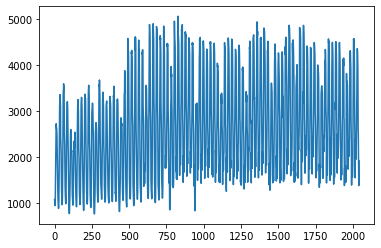

In [60]:
plt.plot(y)

In [61]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=X_oh,
#     num_features=X_oh.columns,
#     corr_cutoff=0.7,
# )
# X_oh      = interaction_maker.transform(X_oh)
# X_test_oh = interaction_maker.transform(X_test_oh)

# X_oh      = delete_unique_columns(X_oh,verbose=False)
# X_test_oh = X_test_oh[X_oh.columns]

In [62]:
# X_oh['period'] = range(len(X_oh))
# X_test_oh['period'] = [X_oh['period'].max()+i for i in range(len(X_test_oh))]

In [63]:
# y = np.log(y)
# y = np.sqrt(y)

In [64]:
y_scaler = None

# from sklearn.preprocessing import MinMaxScaler

# y_scaler = MinMaxScaler()
# scaled = y_scaler.fit_transform(np.array(y).reshape(-1,1))
# y = pd.Series(scaled.flatten())

In [65]:
# from scipy.signal import find_peaks

# # 진폭 주기 산출
# peaks, _ = find_peaks(y,distance=12)  # 데이터셋에서 최댓값 인덱스를 찾습니다.
# troughs, _ = find_peaks(-y,distance=12)  # 데이터셋에서 최솟값 인덱스를 찾습니다.

# # 진폭 주기를 계산합니다.
# amplitude_period = min(np.mean(np.diff(peaks)), np.mean(np.diff(troughs)))
# amplitude_period = int(round(amplitude_period,0)) 

# # 결과 출력
# print("Amplitude Period:", amplitude_period)

# plt.figure(figsize=(15,7))
# plt.plot(range(len(y)),y)
# plt.grid()
# for _ in peaks:
#     plt.axvline(_,color='red',linestyle='--')
# plt.show()

In [66]:
X_oh.shape,X_test_oh.shape

((2040, 82), (168, 82))

In [67]:
from torch.utils.data.dataset import random_split, Subset

window_size = 24

train_size = 0.95
batch_size = 64
num_workers = 0
shuffle = False

In [68]:
# dataset = TimeSeriesDataset(pd.concat([X_oh,y],axis=1).values,window_size=window_size)
# # dataset = TimeSeriesDataset(y.values,window_size=24)

# n_train = int(train_size*len(dataset))
# n_val   = len(dataset)-n_train
# generator = torch.Generator().manual_seed(CFG.SEED)
# # generator = None
# train_dataset, valid_dataset = random_split(dataset,[n_train,n_val],generator=generator)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [69]:
dataset = TimeSeriesDataset(pd.concat([X_oh,y],axis=1).values,window_size=window_size)
# dataset = TimeSeriesDataset(y.values,window_size=24)

n_train = int(train_size*len(dataset))
n_train = n_train - n_train%24
print('> train: {:.0f}day, validation: {:.0f}day'.format(n_train/24,(len(dataset)-n_train)/24))

train_idx = [i for i in range(len(dataset)) if i<n_train]
valid_idx = [i for i in range(len(dataset)) if i>=n_train]

train_dataset = Subset(dataset,train_idx)
valid_dataset = Subset(dataset,valid_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

> train: 79day, validation: 5day


In [70]:
test_data = pd.concat([
    X_oh.tail(window_size).assign(y=y),
    X_test_oh.assign(y=np.mean(y)),
],axis=0).reset_index(drop=True)
# test_data = pd.concat([
#     X_oh.tail(24).assign(y=y)['y'],
#     X_test_oh.assign(y=np.mean(y))['y'],
# ],axis=0).reset_index(drop=True)

test_dataset = TimeSeriesDataset(test_data.values,window_size=window_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [71]:
# from torch.utils.data.dataset import random_split

# batch_size = 32
# num_workers = 0
# shuffle = True

# window_size = 1
# sequence_size = 24
# future_size = len(X_test_oh)

# train_size = 0.75
# dataset = TimeSeriesDataset(X_oh,y,window_size,sequence_size,future_size,infer_mode=False)

# n_train = int(train_size*len(dataset))
# n_val   = len(dataset)-n_train
# generator = torch.Generator().manual_seed(CFG.SEED)
# train_dataset, valid_dataset = random_split(dataset,[n_train,n_val],generator=generator)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [72]:
# len(train_dataset.tr_seq)
# train_dataset.tr_seq

In [73]:
# test_data = pd.concat([
#     X_oh.tail(sequence_size).assign(y=y),
#     X_test_oh.assign(y=np.nan),
# ],axis=0).reset_index(drop=True)

# test_dataset = TimeSeriesDataset(test_data.drop('y',axis=1),test_data['y'],window_size,sequence_size,future_size,infer_mode=True)
# test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [74]:
# [_x for _x,_y in train_loader][0]
# [_x.shape for _x,_y in train_loader]
len(train_loader), len(valid_loader), len(test_loader)

(30, 2, 3)

In [75]:
X_test_oh.shape[0],sum([x.size(0) for x,y in test_loader])

(168, 168)

In [76]:
# https://jimmy-ai.tistory.com/342
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
import numpy as np
import torch
import torch.nn as nn
import time
from tqdm import tqdm, trange

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# # https://github.com/pytorch/pytorch/issues/21987
# def nanmean(v, *args, inplace=False, **kwargs):
#     if not inplace:
#         v = v.clone()
#     is_nan = torch.isnan(v)
#     v[is_nan] = 0
#     return v.sum(*args, **kwargs) / (~is_nan).float().sum(*args, **kwargs)

# def seq2list_cuda(seq,device):
#     nan_value = -99999
#     ret_seq = []
#     k=0
#     N=len(seq)
#     for x in seq:
#         start_seq = torch.tensor([nan_value]*k).to(device).float()
#         end_seq   = torch.tensor([nan_value]*(N-k-1)).to(device).float()
#         x = x.to(device)
        
#         if len(start_seq)==0:
#             _seq  = torch.cat([x,end_seq],axis=0)
#         elif len(end_seq)==0:
#             _seq  = torch.cat([start_seq,x],axis=0)
#         else:
#             _seq  = torch.cat([start_seq,x,end_seq],axis=0)
            
#         _seq[_seq==nan_value] = float('nan')
#         ret_seq.append(_seq)
#         k+=1
#     ret_seq = torch.stack(ret_seq,dim=0)
#     #print('(1)',ret_seq)
#     ret_seq = nanmean(ret_seq,dim=0)
#     #print('(2)',ret_seq)
#     return ret_seq
        
import numpy as np
import pandas as pd
import time
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import collections

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython
def live_plot(data_dict, figsize=(15,9), title='',**kwargs):
    #global plot_df
    plot_df = pd.DataFrame(data_dict)
    
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    sns.lineplot(x=range(len(plot_df)),y=plot_df['train_loss'],color='gray',label='Train Loss')
    sns.scatterplot(x=range(len(plot_df)),y=plot_df['train_loss'],hue=plot_df['is_best'],
                    palette=['gray','red'] ,legend=False,**kwargs)
    sns.lineplot(x=range(len(plot_df)),y=plot_df['test_loss'],color='black',label='Test Loss')
    sns.scatterplot(x=range(len(plot_df)),y=plot_df['test_loss'] ,hue=plot_df['is_best'],
                    palette=['black','red'],legend=False,**kwargs)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=2,bbox_to_anchor=(1,1)) # the plot evolves to the right
    
    plt.tight_layout()
    plt.show()

def train(
    model, train_dataloader, test_dataloader,
    criterion, optimizer, scheduler=None, device='cpu', 
    num_epochs=100, metric_period=10,
    early_stopping=None,
    plot=True, use_best_model=True,
    eval_metric=None,
    **plot_kwargs
):
    is_best = 0
    best_epoch = 0
    best_test_loss = float('inf')
    best_model = None

    is_best_list = []
    plot_dict = collections.defaultdict(list)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # 학습
        model.train()
        tr_preds,tr_trues = [],[]
        for i, (x, y) in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc='trainset'):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_preds.append(outputs)
            tr_trues.append(y)
            
        tr_preds = torch.concatenate(tr_preds,axis=0)
        tr_trues = torch.concatenate(tr_trues,axis=0)
        train_loss = criterion(tr_preds,tr_trues).item()
        if eval_metric is not None:
            train_eval_loss = eval_metric(outputs, y).item()
            
        # print('> train')
        # print('pred:',tr_preds[:10])
        # print('true:',tr_trues[:10])
        # print('smape:',smape(pred=np.array(tr_preds),true=np.array(tr_trues)))
        # print('')

        # 검증
        te_preds,te_trues = [],[]
        #model.eval()
        with torch.no_grad():
            for i, (x, y) in tqdm(enumerate(test_dataloader),total=len(test_dataloader),desc='testset'):
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                te_preds.append(outputs)
                te_trues.append(y)
            
            te_preds = torch.concatenate(te_preds,axis=0)
            te_trues = torch.concatenate(te_trues,axis=0)
            test_loss = criterion(outputs,y).item()
            if eval_metric is not None:
                test_eval_loss = eval_metric(outputs, y).item()
                
        # print('> validation')
        # print('pred:',te_preds[:10])
        # print('true:',te_trues[:10])
        # print('smape:',smape(pred=np.array(te_preds),true=np.array(te_trues)))
        # print('')
        
        # #MSE -> RMSE
        # train_loss = np.sqrt(train_loss)
        # test_loss  = np.sqrt(test_loss)
        
        if scheduler is not None:
            scheduler.step(test_loss)

        if use_best_model:
            if test_loss < best_test_loss:
                torch.save(model.state_dict(), './mc/best_model.pt')
        else:
            torch.save(model.state_dict(), './mc/best_model.pt')
            
        # test_loss가 더 좋아졌을 경우 모델 저장 및 업데이트
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = model
            is_best=1
            best_epoch=epoch
        else:
            is_best=0
            
        epoch_end_time = time.time()
        if plot:
            epoch_run_time = epoch_end_time - epoch_start_time
            total_run_time = epoch_run_time*(num_epochs-(epoch+1))
            str_epoch = str(epoch+1).zfill(len(str(num_epochs)))
            
            plot_dict['train_loss'].append(train_loss)
            plot_dict['test_loss'].append(test_loss)
            plot_dict['is_best'].append(is_best)
            plot_dict['best_test_loss'].append(best_test_loss)
            plot_dict['best_epoch'].append(best_epoch)
            if eval_metric is not None:
                plot_dict['train_eval_loss'].append(train_eval_loss)
                plot_dict['test_eval_loss'].append(test_eval_loss)
                title = '[TensorBoard]\nEpoch: {} / {}\n[loss] train: {:.4f}, val: {:.4f}, best: {:.4f} ({})\n[eval_metric] train: {:.4f}, val: {:.4f}\nElapsed: {:.2f}s, Total: {:.2f}s'\
                    .format(str_epoch,num_epochs,train_loss,test_loss,best_test_loss,best_epoch,train_eval_loss,test_eval_loss,epoch_run_time,total_run_time)
            else:
                title = '[TensorBoard]\nEpoch: {} / {}\n[loss] train: {:.4f}, val: {:.4f}, best: {:.4f} ({})\nElapsed: {:.2f}s, Total: {:.2f}s'\
                    .format(str_epoch,num_epochs,train_loss,test_loss,best_test_loss,best_epoch,epoch_run_time,total_run_time)
            live_plot(plot_dict,title=title,**plot_kwargs)
        else:
            if (epoch+1)%metric_period==0:
                epoch_run_time = epoch_end_time - epoch_start_time
                total_run_time = epoch_run_time*(num_epochs-(epoch+1))
                str_epoch = str(epoch+1).zfill(len(str(num_epochs)))
                
                progress_text = '{}[{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, elapsed: {:.2f}s, total: {:.2f}s'\
                    .format(np.where(is_best==1,'*',' '), str_epoch, num_epochs, 
                            train_loss, test_loss,epoch_run_time,total_run_time)
                print(progress_text)
            
        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                break

    # 모든 epoch이 끝나면 최종 모델 저장
    torch.save(model.state_dict(), './mc/final_model.pt')
    print('Final model saved.')

    return best_model

def predict(best_model,loader,device,scaler,infer_mode=False): #transform_y
    best_model.to(device)
    #best_model.eval()
    
    true_list = []
    pred_list = []
    with torch.no_grad():
        for _ in tqdm(loader):
            if infer_mode:
                data = _
            else:
                data,label = _
            data = data.float().to(device)

            output = best_model(data).cpu().numpy().flatten().tolist()
            if not infer_mode:
                label  = label.cpu().numpy().flatten().tolist()
            
            if scaler is not None:
                output = scaler.inverse_transform(np.array(output).reshape(-1,1)).flatten().tolist()
                if not infer_mode:
                    label  = scaler.inverse_transform(np.array(label) .reshape(-1,1)).flatten().tolist()

            #if transform_y=='log':
            #    output = np.exp(output).tolist()
            #    label  = np.exp(label).tolist()
            #elif transform_y=='sqrt':
            #    output = np.square(output).tolist()
            #    label  = np.square(label).tolist()

            if not infer_mode:
                true_list += label
            pred_list += output

    if infer_mode:
        return pred_list
    else:
        return true_list, pred_list

In [77]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = X_oh.shape[1]+1
hidden_size = 64
num_layers = 1
output_size = 1
learning_rate = 0.003
dropout = 0.5
num_epochs = 256

model = BiLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    bidirectional=False,
    dropout=dropout,
    seq_len=window_size,
    batch_norm=True,
    activation=nn.GELU(),
    init_weight=True,
).to(device)

# model = LSTM(input_size,hidden_size,num_layers,output_size).to(device)

# model = SimpleNN(input_size,hidden_size,output_size,activation=nn.ReLU(),dropout=dropout)

cpu


In [84]:
def smape_loss(true, pred):
    v = 2 * torch.abs(pred - true) / (torch.abs(pred) + torch.abs(true))
    output = torch.mean(v) * 100
    return output

In [85]:
gc_collect_all()

gc_collect: 18822
gc_collect: 35160


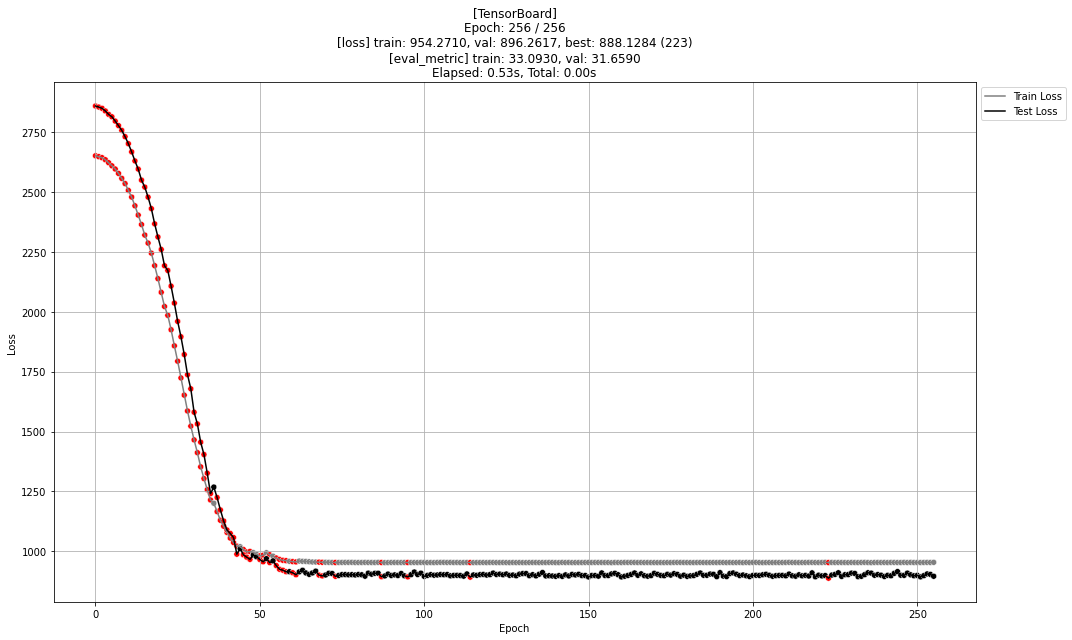

Final model saved.


In [86]:
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate, weight_decay=5e-4)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-7, verbose=True)
# scheduler = None
# es = EarlyStopping(patience=30,verbose=False,path='./mc/es.pt')
es = None

best_model = train(
    model,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    metric_period=1,
    early_stopping=es,
    plot=True,
    use_best_model=True,
    eval_metric=smape_loss,
)

In [ ]:
# best_model.state_dict()

In [ ]:
best_model = model
best_model.load_state_dict(torch.load('./mc/best_model.pt'))

In [87]:
def identity(x):
    return x

In [88]:
tr_true, tr_pred = predict(best_model,train_loader,device,scaler=y_scaler,infer_mode=False)
va_true, va_pred = predict(best_model,valid_loader,device,scaler=y_scaler,infer_mode=False)

func = identity
# func = np.exp

tr_true = func(tr_true)
tr_pred = func(tr_pred)
va_true = func(va_true)
va_pred = func(va_pred)

100%|██████████| 2/2 [00:00<00:00, 116.17it/s]


In [89]:
# s = MinMaxScaler(feature_range=(min(tr_true),max(tr_true)))
# s.fit(np.array(tr_pred).reshape(-1,1))
# tr_pred = s.transform(np.array(tr_pred).reshape(-1,1)).flatten()
# va_pred = s.transform(np.array(va_pred).reshape(-1,1)).flatten()

In [90]:
len(predict(best_model,test_loader,device,scaler=y_scaler,infer_mode=False)[1]), test_fn[test_fn[segment_feature]==segment].shape

100%|██████████| 3/3 [00:00<00:00, 95.04it/s]


(168, (168, 62))

In [91]:
len(tr_true), len(tr_pred), len(va_true), len(va_pred)

(1896, 1896, 120, 120)

In [92]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true=tr_true,y_pred=tr_pred)

956.1630300529898

In [93]:
# tmp = []
# for _x,_y in train_loader:
#     tmp += _y.numpy().tolist()    
# plt.plot(tmp)

In [94]:
# plt.plot(np.array(tr_true)-np.array(tr_pred))
# plt.axhline(0,color='red',linestyle='--')

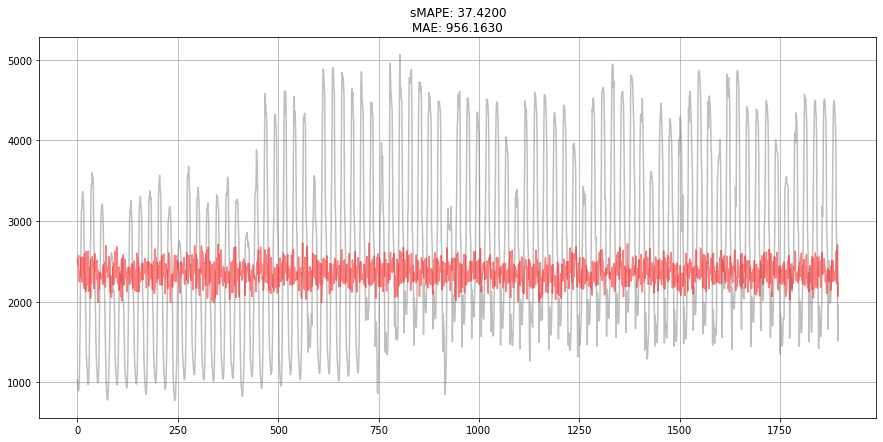

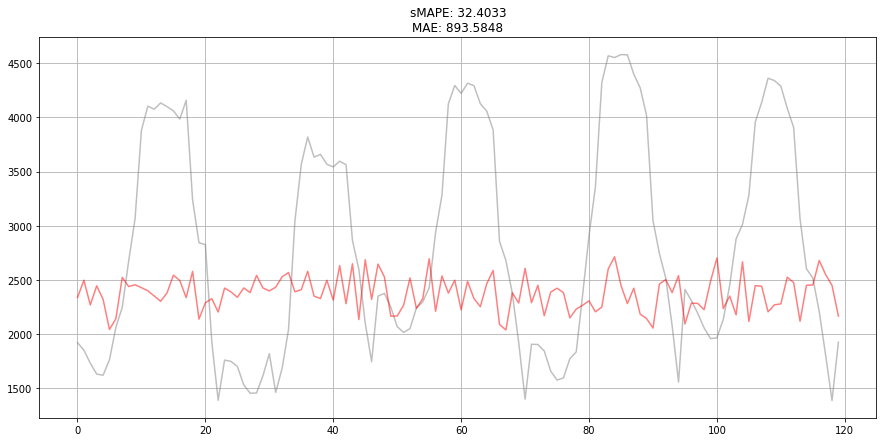

In [95]:
# true = tr_true + va_true
# pred = tr_pred + va_pred

from sklearn.metrics import mean_absolute_error

def prediction_check(true,pred):
    _smape = smape(true=np.array(true),pred=np.array(pred))
    _mae   = mean_absolute_error(y_true=true,y_pred=pred)
    
    plt.figure(figsize=(15,7))
    sns.lineplot(x=range(len(true)),y=true,color='gray',alpha=0.5)
    sns.lineplot(x=range(len(pred)),y=pred,color='red',alpha=0.5)
    #sns.scatterplot(x=range(len(true)),y=true,color='gray',alpha=0.5)
    #sns.scatterplot(x=range(len(pred)),y=pred,color='red',alpha=0.5)
    #plt.axvline(len(tr_true),color='red',linestyle='--')
    plt.grid()
    plt.title('sMAPE: {:.4f}\nMAE: {:.4f}'.format(_smape,_mae))
    plt.show()
    
prediction_check(tr_true,tr_pred)
prediction_check(va_true,va_pred)

100%|██████████| 3/3 [00:00<00:00, 104.46it/s]


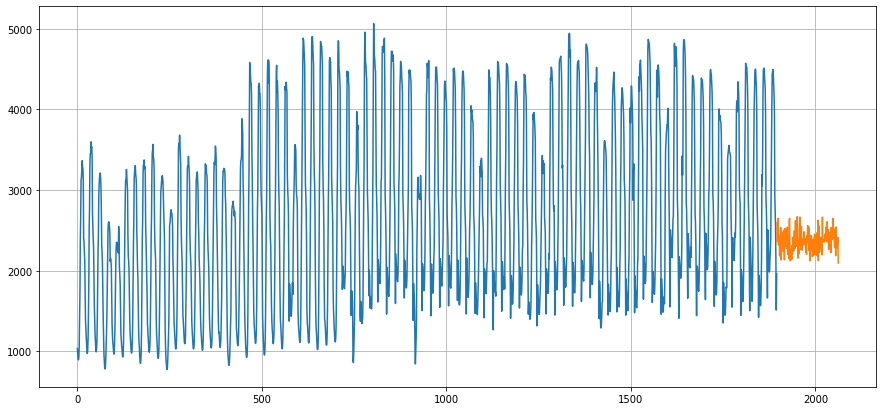

In [96]:
a = tr_true
b = predict(best_model,test_loader,device,scaler=y_scaler,infer_mode=False)[1]

b = func(b)
# b = s.transform(np.array(b).reshape(-1,1)).flatten()

plt.figure(figsize=(15,7))
sns.lineplot(x=range(len(a)),y=a)
sns.lineplot(x=[max(range(len(a)))+i for i in range(len(b))],y=b)
plt.grid()
plt.show()

In [ ]:
# del TimeSeriesDataset

In [ ]:
# class TimeSeriesDataset(Dataset):
#     def __init__(self, df, window_size):
#         self.df = df
#         self.window_size = window_size

#     def __len__(self):
#         return len(self.df) - self.window_size

#     def __getitem__(self, idx):
#         x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
#         if self.df.shape[1] > 1:
#             y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
#         else:
#             y = None
#         return x, y

# def create_data_loader(df, window_size, batch_size):
#     dataset = TimeSeriesDataset(df, window_size)
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     return data_loader

In [ ]:
# train_loader = create_data_loader(pd.concat([X_oh,y],axis=1).values, window_size=24, batch_size=16)

In [ ]:
# input_size = X_oh.shape[1]
input_size = 21
hidden_size = 128
num_layers = 1
output_size = 1
learning_rate = 0.9
num_epochs = 256
learning_rate = 0.3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM(input_size, hidden_size, num_layers, output_size)#.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    tr_loss_list = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tr_loss_list.append(loss.item())
        
    progress = 'Epoch [{}/{}], loss: {:.4f}' \
        .format(str(epoch+1).zfill(len(str(num_epochs))),num_epochs,np.mean(tr_loss_list))
        
#     va_loss_list = []
#     for i, (inputs, labels) in enumerate(valid_loader):
#         inputs = inputs.to(device)
#         labels = labels.unsqueeze(1).to(device)

#         # Forward
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         va_loss_list.append(loss.item())
        
#     progress = 'Epoch [{}/{}], loss: {:.4f}, val_loss: {:.4f}' \
#         .format(str(epoch+1).zfill(len(str(num_epochs))),num_epochs,np.mean(tr_loss_list),np.mean(va_loss_list))
    print (progress)

In [ ]:
tr_true, tr_pred = predict(model,train_loader,device)
va_true, va_pred = predict(model,valid_loader,device)

In [ ]:
len(tr_true), len(tr_pred), len(va_true), len(va_pred)

In [ ]:
true = tr_true + va_true
pred = tr_pred + va_pred

plt.figure(figsize=(15,7))
sns.lineplot(x=range(len(true)),y=true,color='gray',alpha=0.5)
sns.lineplot(x=range(len(pred)),y=pred,color='red',alpha=0.5)
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.grid()
plt.show()

<br></br>

# Inference

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = pred

In [ ]:
submit.head()

In [ ]:
# public : 7.5409287264 (log)
submit.to_csv('./out/8_weiens_noseg_stacking.csv',index=False)